In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def f(X):
    """deterministic truth y=f(x) represented as a function"""
    assert len(X.shape) == 2, "I expect an N-by-p array"
    N,p = X.shape
    return np.sin(X[:,0])

def noise(X, sigma=0.3):
    """ return N samples of noise.  Input X is N-by-p. """
    return np.random.randn(X.shape[0])*sigma

In [3]:
N = 1000  # number of samples
X = np.linspace(0,4*np.pi,N).reshape(N,1)   # make a N-by-1 array of X values

F = f(X)
Y = f(X) + noise(X)

# train/test split all the things 
Xtrain,Xtest,Ytrain,Ytest,Ftrain, Ftest = train_test_split(X, Y, F, test_size=0.25)

In [4]:
# Make a model and fit!
# Make sure we fit the model to Y not F.  Otherwise, we are cheating!

k=3
m = DecisionTreeRegressor(max_depth=k)
m.fit(Xtrain, Ytrain)

# Produce the training Yhat and the testing Yhat

Yhattrain = m.predict(Xtrain)
Yhattest = m.predict(Xtest)

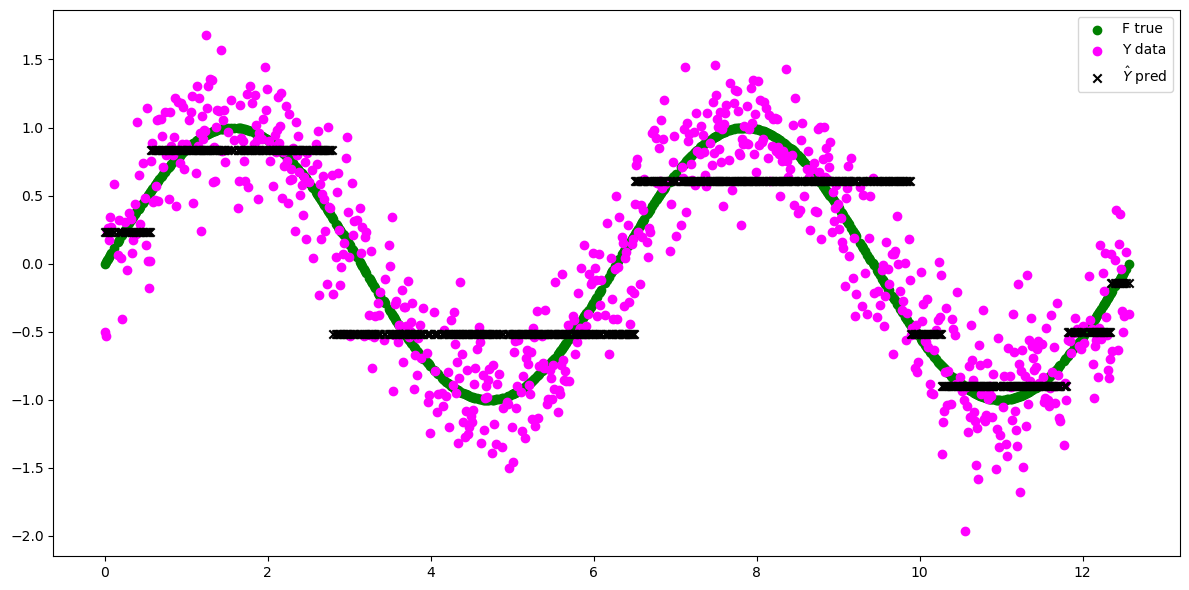

In [5]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.scatter(Xtrain, Ftrain, color='green',label="F true")
ax.scatter(Xtrain, Ytrain, color='magenta', marker='o', label="Y data")
ax.scatter(Xtrain, Yhattrain, color='black', marker='x', label="$\hat{Y}$ pred")
#ax.scatter(Xtrain, [Yhattrain.mean()]*Xtrain.shape[0], label='$E[\hat{Y}]$')

ax.legend()
plt.tight_layout()
plt.show()

In [6]:
def resample(x, std=0.05, N=1000):
    """ Re-sample near a sample point x with round Normal noise"""
    assert len(x.shape) == 1, "I expect a single point in p-diml space"
    p = x.shape[0]
    X = x.reshape(1,p) + np.random.randn(N,p)*std
    return X

def tradeoffs(X, model, f, noise):
    r""" Collect the bias/variance tradeoff numbers by resampling."""
    
    MSE_all = []
    VAR_all = []
    BIAS2_all = []
    ES2_all = []
    XXX_all = []
    TOT_all = []
    
    for x in X:
        X_samp = resample(x)
        F_samp = f(X_samp)
        E_samp = noise(X_samp)
        Y_samp = F_samp + E_samp
        Yhat_samp = model.predict(X_samp)
        
        MSE_samp = np.mean( (F_samp + E_samp - Yhat_samp)**2 )
        VAR_samp = np.mean( (Yhat_samp - Yhat_samp.mean())**2 )
        BIAS2_samp = np.mean( (F_samp.mean() - Yhat_samp.mean()) )**2
        ES2_samp = np.mean( (E_samp - E_samp.mean())**2 )       
        XXX_samp = 2*np.mean( (F_samp-Yhat_samp.mean())*E_samp + (Yhat_samp.mean()-Yhat_samp)*E_samp + (Yhat_samp.mean()-Yhat_samp)*(F_samp - Yhat_samp.mean()) )

        
        MSE_all.append(MSE_samp)
        VAR_all.append(VAR_samp)
        BIAS2_all.append(BIAS2_samp)
        ES2_all.append(ES2_samp)
        XXX_all.append(XXX_samp)
        TOT_all.append(VAR_samp + BIAS2_samp + ES2_samp + XXX_samp)

    return  {'mean_squared_error': np.mean(MSE_all),
            'variance' :np.mean(VAR_all),
            'bias2': np.mean(BIAS2_all),
            'sigma2': np.mean(ES2_all),
            'cross_terms': np.mean(XXX_all),
            'total': np.mean(TOT_all)}

In [7]:
d = tradeoffs(Xtrain, m, f, noise)

print(d)

{'mean_squared_error': 0.1901442664396159, 'variance': 0.012605446861059891, 'bias2': 0.08906396883171772, 'sigma2': 0.08963670527468416, 'cross_terms': -0.0024521128661142873, 'total': 0.1888540081013475}


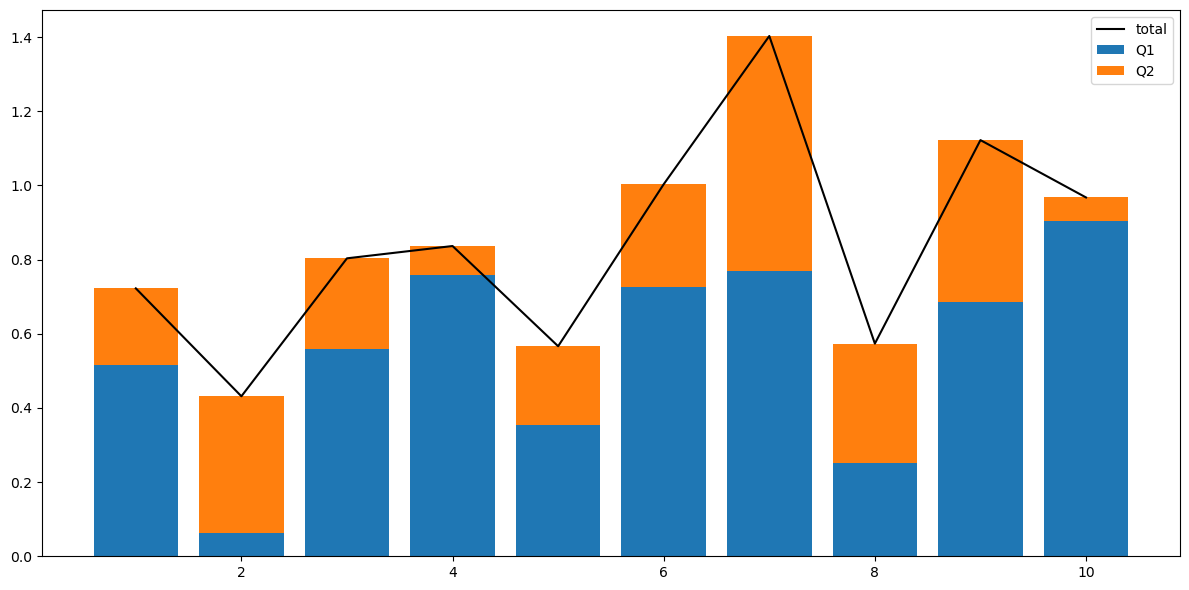

In [8]:
ks = np.arange(1,11)
quantity1 = np.random.random(10)
quantity2 = np.random.random(10)


fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.bar(ks, quantity1, label="Q1")
ax.bar(ks, quantity2, label="Q2", bottom=quantity1)
ax.plot(ks, quantity1 + quantity2, label="total", color='black')


ax.legend()
plt.tight_layout()
plt.show()

In [17]:
knr_df = pd.DataFrame()

for k in range(1, 21):
  m = KNeighborsRegressor(n_neighbors=k)
  m.fit(Xtrain, Ytrain)
  t = tradeoffs(Xtrain, m, f, noise)
  t['k'] = k
  knr_df = knr_df.append(t, ignore_index=True)

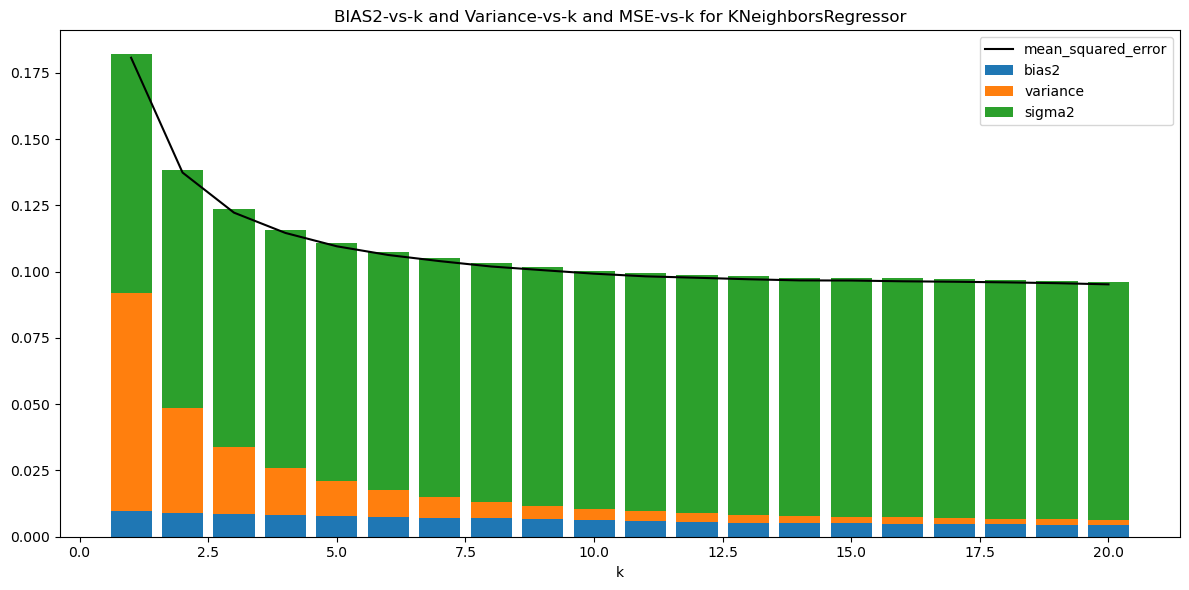

In [19]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.bar(knr_df['k'], knr_df['bias2'], label='bias2')
ax.bar(knr_df['k'], knr_df['variance'], label='variance', bottom=knr_df['bias2'])
ax.bar(knr_df['k'], knr_df['sigma2'], label='sigma2', bottom=knr_df['bias2']+knr_df['variance'])
ax.plot(knr_df['k'], knr_df['mean_squared_error'], label="mean_squared_error", color='black')

ax.legend()
plt.title('BIAS2-vs-k and Variance-vs-k and MSE-vs-k for KNeighborsRegressor')
plt.xlabel('k')
plt.tight_layout()
plt.show()

In [20]:
dtr_df = pd.DataFrame()

for k in range(1, 21):
  m = DecisionTreeRegressor(max_depth=k)
  m.fit(Xtrain, Ytrain)
  t = tradeoffs(Xtrain, m, f, noise)
  t['k'] = k
  dtr_df = dtr_df.append(t, ignore_index=True)

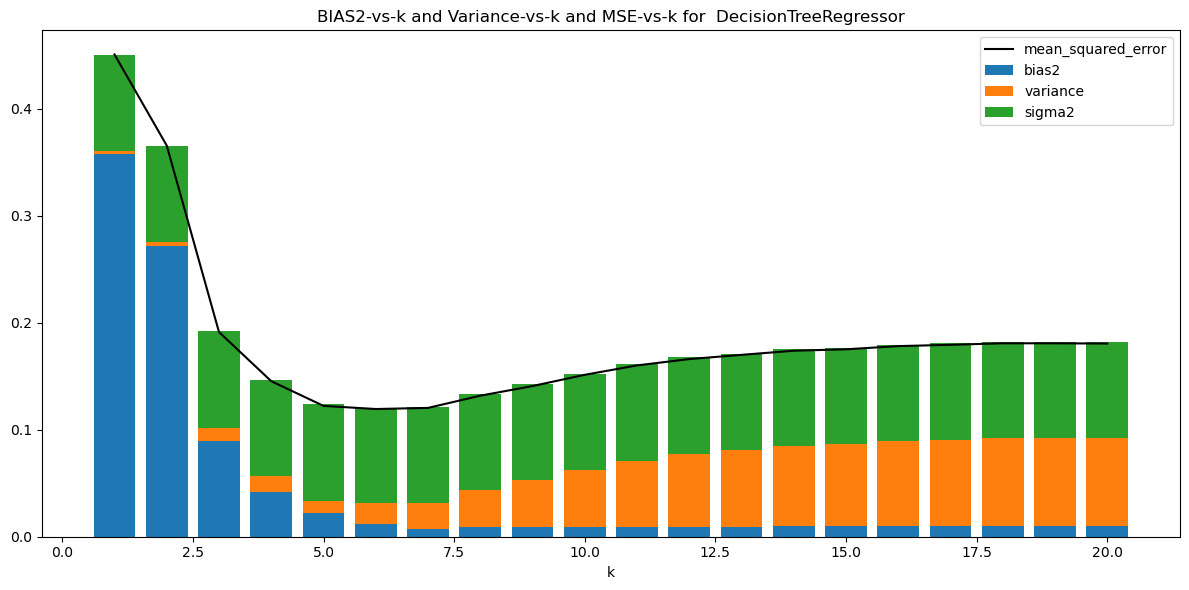

In [21]:
fig,ax = plt.subplots(1, figsize=(12,6), dpi=100)
ax.bar(dtr_df['k'], dtr_df['bias2'], label='bias2')
ax.bar(dtr_df['k'], dtr_df['variance'], label='variance', bottom=dtr_df['bias2'])
ax.bar(dtr_df['k'], dtr_df['sigma2'], label='sigma2', bottom=dtr_df['bias2']+dtr_df['variance'])
ax.plot(dtr_df['k'], dtr_df['mean_squared_error'], label="mean_squared_error", color='black')

ax.legend()
plt.title('BIAS2-vs-k and Variance-vs-k and MSE-vs-k for  DecisionTreeRegressor')
plt.xlabel('k')
plt.tight_layout()
plt.show()